In [1]:
import os
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import sentencepiece as spm
from sklearn.model_selection import train_test_split
import numpy as np
from nltk.translate.bleu_score import corpus_bleu
from datetime import datetime
import re
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPUs available")

Number of GPUs: 1
GPU 0: NVIDIA GeForce RTX 2070 SUPER


In [2]:
with open('eng_-french.csv', 'r', encoding='utf-8') as f, \
     open('english.txt', 'w', encoding='utf-8') as en, \
     open('french.txt', 'w', encoding='utf-8') as fr:
    for line in f:
        clean_line = " ".join(line.strip().split())
        english_sentence, french_sentence = clean_line.strip().split(',', 1)
        english_sentence = re.sub('([.,!?()"])', r' \1 ', english_sentence)
        english_sentence = re.sub('\s{2,}', ' ', english_sentence)
        french_sentence = re.sub('([.,!?()"])', r' \1 ', french_sentence)
        french_sentence = re.sub('\s{2,}', ' ', french_sentence)
        fr.write('' + french_sentence + '\n')
        en.write('' + english_sentence + '\n')
    f.close()
    en.close()
    fr.close()

In [3]:
# using french as the source language and english as the target
spm.SentencePieceTrainer.Train(input='french.txt',pad_id=0,unk_id=3,model_prefix='sourcemodel',vocab_size=32000,character_coverage=0.9995,model_type='bpe',control_symbols=['<s>','</s>'])
spm.SentencePieceTrainer.Train(input='english.txt',pad_id=0,unk_id=3,model_prefix='targetmodel',vocab_size=32000,character_coverage=0.9995,model_type='bpe',control_symbols=['<s>','</s>'])

# Load the trained models
sp_source = spm.SentencePieceProcessor()
sp_source.Load('sourcemodel.model')

sp_target = spm.SentencePieceProcessor()
sp_target.Load('targetmodel.model')

sos_fr = sp_source.piece_to_id('<s>')
eos_fr = sp_source.piece_to_id('</s>')

sos_en = sp_target.piece_to_id('<s>')
eos_en = sp_target.piece_to_id('</s>')

# Tokenize example
tokens_fr = []
french = open('french.txt', 'r')
Lines = french.readlines()
for line in Lines:
    tokens_fr.append([sos_fr] + sp_source.EncodeAsIds(line) + [eos_fr])


tokens_en = []
english = open('english.txt', 'r')
Lines = english.readlines()
for line in Lines:
    tokens_en.append([sos_en] + sp_target.EncodeAsIds(line) + [eos_en])


tokens_fr = tokens_fr[1:]
tokens_en = tokens_en[1:]

print(tokens_fr[0:15])
print(tokens_en[0:15])

[[1, 8168, 152, 2], [1, 19397, 152, 2], [1, 19807, 152, 2], [1, 547, 36, 2], [1, 31927, 3, 31930, 1451, 152, 2], [1, 1027, 1174, 152, 2], [1, 31927, 3, 11, 31944, 1167, 152, 2], [1, 13783, 4, 2], [1, 31927, 3, 31930, 4360, 152, 2], [1, 6759, 282, 152, 2], [1, 1129, 31935, 3, 919, 31953, 1146, 152, 2], [1, 3646, 152, 2], [1, 3710, 152, 2], [1, 15864, 4, 2], [1, 6730, 4, 2]]
[[1, 6330, 4, 2], [1, 5518, 412, 2], [1, 5518, 412, 2], [1, 421, 33, 2], [1, 6350, 412, 2], [1, 8180, 412, 2], [1, 2438, 412, 2], [1, 8737, 4, 2], [1, 1052, 412, 2], [1, 1052, 412, 2], [1, 1052, 412, 2], [1, 2134, 412, 2], [1, 2134, 412, 2], [1, 1062, 83, 4, 2], [1, 1062, 83, 4, 2]]


Longest sequence length: 40
Average sequence length: 9.64
90th percentile sequence length: 13.0


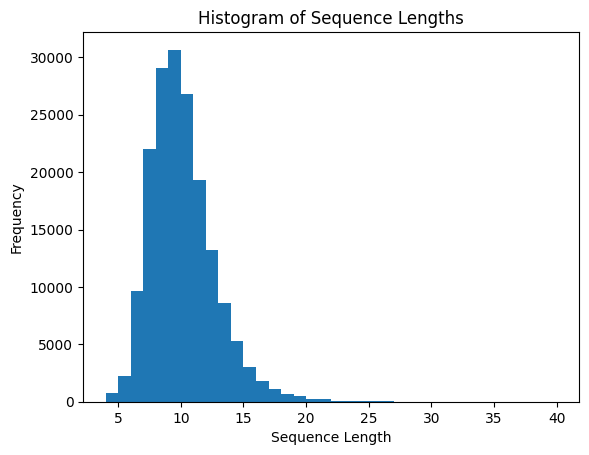

In [4]:
# Calculate the lengths of each sequence
sequence_lengths = [len(seq) for seq in tokens_en]

# Calculate the statistics
longest_sequence = max(sequence_lengths)
average_sequence_length = np.mean(sequence_lengths)
percentile_90_length = np.percentile(sequence_lengths, 90)

# Output the stats
print(f"Longest sequence length: {longest_sequence}")
print(f"Average sequence length: {average_sequence_length:.2f}")
print(f"90th percentile sequence length: {percentile_90_length}")

# Plot the histogram
plt.hist(sequence_lengths, bins=range(min(sequence_lengths), max(sequence_lengths) + 1))
plt.title('Histogram of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

In [5]:
# Split data into training and testing (80-20 split, for example)
en_train, en_temp, fr_train, fr_temp = train_test_split(tokens_en, tokens_fr, test_size=0.2, random_state=42)

# Split the temp data again into validation and test sets (50-50 split)
en_val, en_test, fr_val, fr_test = train_test_split(en_temp, fr_temp, test_size=0.5, random_state=42)

buffer_train = len(en_train)
buffer_val = len(en_val)
buffer_test = len(en_test)
print(buffer_train)
print(buffer_val)
print(buffer_test)

140496
17562
17563


In [6]:
def create_masks(padded_sequences):
    mask = (padded_sequences == 0).int()  
    return mask.unsqueeze(1).unsqueeze(2)

class TranslationDataset(Dataset):
    def __init__(self, source_data, target_data):
        self.source_data = source_data
        self.target_data = target_data

    def __len__(self):
        return len(self.source_data)

    def __getitem__(self, idx):
        source = self.source_data[idx]
        target = self.target_data[idx]
        source_tensor = torch.tensor(source, dtype=torch.int32)
        target_tensor = torch.tensor(target, dtype=torch.int32)
        return source_tensor, target_tensor


def collate_fn(batch):
    inp, tar = zip(*batch)
    
    # Pad sequences to the length of the longest sequence in the batch
    inp_padded = pad_sequence(inp, batch_first=True, padding_value=0)
    tar_padded = pad_sequence(tar, batch_first=True, padding_value=0)
    
    # Create masks for the padded sequences
    mask_inp = create_masks(inp_padded)
    mask_tar = create_masks(tar_padded)
    
    return (inp_padded, mask_inp), (tar_padded, mask_tar)

# Create dataset instances
train_dataset = TranslationDataset(fr_train, en_train)
val_dataset = TranslationDataset(fr_val, en_val)
test_dataset = TranslationDataset(fr_test, en_test)

batch_size = 64

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [41]:
# Initialize a counter
counter = 0

# Iterate over the DataLoader
for (source_batch, source_masks), (target_batch, target_masks) in train_loader:
    # Flatten the batches into individual samples
    for i in range(len(source_batch)):
        print(f"Sample {counter + 1}:")
        print("Source sequence:", source_batch[i])
        print("Source mask:", source_masks[i])
        print("Target sequence:", target_batch[i])
        print("Target mask:", target_masks[i])
        print("-" * 50)
        
        counter += 1
        
        # Stop after the first 5 samples
        if counter >= 2:
            break
    if counter >= 2:
        break

Sample 1:
Source sequence: tensor([   1,  547,   16,  581,   42,    3,   55, 7670,   36,    2,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0], dtype=torch.int32)
Source mask: tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1]]], dtype=torch.int32)
Target sequence: tensor([   1,  421, 1148,   26, 1046,   33,    2,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0], dtype=torch.int32)
Target mask: tensor([[[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],
       dtype=torch.int32)
--------------------------------------------------
Sample 2:
Source sequence: tensor([    1,    63,    23, 31944, 31961,    16,    37,   584, 31953,  4679,
           41,   121,  1493,   135,   100,   328,     4,     2,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0], 

In [10]:
def get_positional_encoding(max_len, d_model):
    # Create a matrix to store the positional encodings
    pos_enc = np.array([
        [pos / np.power(10000, 2.0 * (j // 2) / d_model) for j in range(d_model)]
        for pos in range(max_len)
    ])

    # Apply the sine to the even indices and the cosine to the odd indices
    pos_enc[:, 0::2] = np.sin(pos_enc[:, 0::2])
    pos_enc[:, 1::2] = np.cos(pos_enc[:, 1::2])

    pos_enc = pos_enc[np.newaxis, ...]  # Add a new dimension for the batch size
    return torch.from_numpy(pos_enc)

In [34]:
def scaled_dot_product_attention(q, k, v, mask=None):
    """
    Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    The mask has different shapes depending on its type (padding or look ahead)
    but it must be broadcastable for addition.
    
    Args:
    - q: query shape == (..., seq_len_q, depth)
    - k: key shape == (..., seq_len_k, depth)
    - v: value shape == (..., seq_len_v, depth_v)
    - mask: Float tensor with shape broadcastable to (..., seq_len_q, seq_len_k). Defaults to None.
    
    Returns:
    - output, attention_weights
    """
    
    # Calculate the dot product
    matmul_qk = torch.matmul(q, k.transpose(-2, -1))

    # Scale the dot product
    d_k = k.shape[-1]
    scaled_attention_logits = matmul_qk / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))

    # Apply the mask if provided
    if mask is not None:
        
        mask = mask.float()
        
        scaled_attention_logits += (mask * -1e9)

    # Softmax to get the attention weights
    attention_weights = F.softmax(scaled_attention_logits, dim=-1)

    # Multiply the attention weights with the value matrix
    output = torch.matmul(attention_weights, v)

    return output, attention_weights

In [12]:
def create_look_ahead_mask(size):
    # Create a lower triangular matrix and subtract it from 1.
    # This will produce a matrix with zeros in its lower triangle and ones elsewhere.
    mask = 1 - torch.triu(torch.ones(size, size))
    return mask  # (seq_len, seq_len)

In [13]:
def pad_to_match(seq1, seq2, padding_value=0):
    len_seq1 = seq1.shape[0]
    len_seq2 = seq2.shape[0]

    padding_seq1 = max(len_seq2 - len_seq1, 0)
    padding_seq2 = max(len_seq1 - len_seq2, 0)

    seq1_padded = F.pad(seq1, (0, padding_seq1), value=padding_value)
    seq2_padded = F.pad(seq2, (0, padding_seq2), value=padding_value)

    return seq1_padded, seq2_padded

In [14]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = nn.Linear(d_model,d_model)
        self.wk = nn.Linear(d_model,d_model)
        self.wv = nn.Linear(d_model,d_model)

        self.fc = nn.Linear(d_model,d_model)
    
    def split_heads(self, x, batch_size):
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        return x.permute(0, 2, 1, 3)

    def forward(self, v, k, q, mask):
        batch_size = q.size(0)

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # Use the previously defined scaled_dot_product_attention function
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = scaled_attention.permute(0, 2, 1, 3)
        concat_attention = scaled_attention.contiguous().view(batch_size, -1, self.d_model)
        
        output = self.fc(concat_attention)

        return output, attention_weights

In [15]:
class PointWiseFeedForwardNetwork(nn.Module):
    def __init__(self, d_model, dff):
        super(PointWiseFeedForwardNetwork, self).__init__()

        self.fc1 = nn.Linear(d_model, dff)  # dff: dimensionality of feed-forward inner layer
        self.fc2 = nn.Linear(dff, dff)  
        self.fc3 = nn.Linear(dff,d_model)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [30]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)  
        self.ffn = PointWiseFeedForwardNetwork(d_model, dff)  

        self.layernorm1 = nn.LayerNorm(d_model,eps=1e-6)
        self.layernorm2 = nn.LayerNorm(d_model,eps=1e-6)

        self.dropout1 = nn.Dropout(rate)
        self.dropout2 = nn.Dropout(rate)

    def forward(self, x, mask=None):

        attn_output, _ = self.mha(x, x, x, mask)  # Self attention
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_vocab_size, d_model)
        self.pos_encoding = get_positional_encoding(maximum_position_encoding, self.d_model).float() 
        
        self.enc_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, dff, rate) 
            for _ in range(num_layers)
        ])

        self.dropout = nn.Dropout(rate)

    def forward(self, x, mask=None):

        seq_length = x.size(1)
        
        # Adding embedding and position encoding
        x = self.embedding(x)  
        x *= torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))
        pos_encoding = self.pos_encoding[:, :seq_length, :]
        x += pos_encoding

        x = self.dropout(x)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, mask)
            
        return x  # (batch_size, input_seq_len, d_model)

In [36]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)  # Self attention
        self.mha2 = MultiHeadAttention(d_model, num_heads)  # Cross attention with encoder's output

        self.ffn = PointWiseFeedForwardNetwork(d_model, dff)

        self.layernorm1 = nn.LayerNorm(d_model,eps=1e-6)
        self.layernorm2 = nn.LayerNorm(d_model,eps=1e-6)
        self.layernorm3 = nn.LayerNorm(d_model,eps=1e-6)

        self.dropout1 = nn.Dropout(rate)
        self.dropout2 = nn.Dropout(rate)
        self.dropout3 = nn.Dropout(rate)

    def forward(self, x, enc_output, combined_mask, enc_padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, combined_mask)  # Self attention
        attn1 = self.dropout1(attn1)
        out1 = self.layernorm1(attn1 + x)
        
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, enc_padding_mask)  # Cross attention
        attn2 = self.dropout2(attn2)
        out2 = self.layernorm2(attn2 + out1)
        
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = nn.Embedding(target_vocab_size, d_model)
        self.pos_encoding = get_positional_encoding(maximum_position_encoding, d_model).float()

        self.dec_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, dff, rate) 
            for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(rate)

    def forward(self, x, enc_output, look_ahead_mask, enc_padding_mask, dec_padding_mask):
        
        look_ahead_mask = look_ahead_mask.float()
        dec_padding_mask = dec_padding_mask.float()
        combined_mask = torch.max(look_ahead_mask, dec_padding_mask)

        seq_length = x.size(1)
        attention_weights = {}

        x = self.embedding(x)
        x *= torch.sqrt(torch.tensor(self.d_model,dtype=torch.float32))
        pos_encoding = self.pos_encoding[:, :seq_length, :]
        x += pos_encoding

        x = self.dropout(x)

        for i, dec_layer in enumerate(self.dec_layers):
            x, block1, block2 = dec_layer(x, enc_output, look_ahead_mask, enc_padding_mask)
            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

        return x, attention_weights  # x.shape == (batch_size, target_seq_len, d_model)

In [18]:
class Transformer(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target, rate)

        self.final_layer = nn.Linear(d_model,target_vocab_size)
    
    def forward(self, inp, tar, enc_padding_mask, 
             look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, look_ahead_mask, enc_padding_mask, dec_padding_mask)
        
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

In [19]:
class CustomSchedule(_LRScheduler):
    def __init__(self, optimizer, d_model, warmup_steps=15000,last_epoch=-1):

        self.d_model = d_model
        self.warmup_steps = warmup_steps
        
        super(CustomSchedule, self).__init__(optimizer, last_epoch)
        
        
    def get_lr(self):
        step = max(1, self.last_epoch)
        arg1 = 1.0 / math.sqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        scale = math.sqrt(self.d_model) * min(arg1, arg2)
        return [base_lr * scale for base_lr in self.base_lrs]

In [20]:
num_layers = 6
d_model = 512
num_heads = 8
dff = 2048
input_vocab_size = 32000
target_vocab_size = 32000
pe_input = 500
pe_target = 500
rate=0.01

transformer = Transformer(num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=rate) 


optimizer = optim.Adam(transformer.parameters(), betas=(0.9, 0.98), eps=1e-9)
learning_rate = CustomSchedule(optimizer,d_model)

checkpoint_path = "./checkpoints/train"

def save_checkpoint(state, filename="checkpoint.pth.tar"):
    torch.save(state, filename)

def load_checkpoint(filename="checkpoint.pth.tar"):
    if os.path.isfile(filename):
        print(f"Loading checkpoint '{filename}'")
        checkpoint = torch.load(filename)
        transformer.load_state_dict(checkpoint['transformer_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        learning_rate.load_state_dict(checkpoint['scheduler_state_dict'])
        print(f"Checkpoint loaded successfully from '{filename}'")
    else:
        print(f"No checkpoint found at '{filename}'")

In [21]:
def loss_function(real, pred):
    mask = (real != 0).float()
    
    # Compute the loss (cross-entropy loss)
    loss_ = F.cross_entropy(pred, real, reduction='none')
    
    # Apply the mask to the loss
    loss_ = loss_ * mask
    
    # Calculate the average loss, ignoring the padding
    return loss_.sum() / mask.sum()

In [38]:
def loss_function_smoothing(real, pred, smoothing_rate=0.1):
    num_classes = pred.size(-1)

    real = real.long()

    # Convert 'real' to a one-hot encoding
    real_one_hot = F.one_hot(real, num_classes=num_classes).float()

    # Apply label smoothing
    real_smoothed = real_one_hot * (1.0 - smoothing_rate) + (smoothing_rate / num_classes)

    # Compute the cross-entropy loss using smoothed labels
    cross_entropy = torch.sum(-real_smoothed * F.log_softmax(pred, dim=-1), dim=-1)

    mask = (real != 0).float()

    loss_ = cross_entropy * mask

    # Calculate the average loss considering the mask
    return torch.sum(loss_) / torch.sum(mask)

In [23]:
def calculate_translation_accuracy(predictions, references):
    
    predictions = torch.tensor(predictions)
    references = torch.tensor(references)

    # Calculate the total number of tokens (excluding padding)
    total_tokens = torch.sum(references != 0)  # Assuming 0 is the padding token

    # Calculate the number of correct predictions
    correct_predictions = torch.sum((predictions == references) & (references != 0))

    # Calculate accuracy
    accuracy = correct_predictions.item() / total_tokens.item()
    return accuracy

In [24]:
def calculate_accuracy(logits, targets, padding_value=0):
    
    predictions = torch.argmax(logits, dim=-1)
    mask = targets != padding_value
    masked_predictions = predictions[mask]
    masked_targets = targets[mask]
    correct_predictions = (masked_predictions == masked_targets).float()
    accuracy = correct_predictions.mean().item()
    
    return accuracy

In [25]:
def validate(transformer, val_loader, n_translations=5):
    transformer.eval()
    generated_sequences = []
    actual_sequences = []
    samples = 0
    acc = 0.0
    loss = 0.0
    
    with torch.no_grad():
        for batch, ((inp, mask_inp), (tar, mask_tar)) in enumerate(val_loader):
            generated_sequence, avg_loss = generate_output(transformer, inp, tar, mask_inp)
            generated_list = generated_sequence.squeeze(0).cpu().tolist()
            generated_sentence = sp_target.DecodeIds(generated_list)
            generated_sequences.append(generated_sentence.split())
            
            actual_sequence = tar[:, 1:]
            actual_list = actual_sequence.squeeze(0).cpu().tolist()
            actual_sentence = sp_target.DecodeIds([int(token) for sublist in actual_list for token in sublist])
            actual_sequences.append([actual_sentence.split()])
            
            samples += 1
            a_pad, g_pad = pad_to_match(tar.squeeze(), generated_sequence)
            accuracy = calculate_translation_accuracy(g_pad, a_pad)
            acc += accuracy
            loss += avg_loss
            
            if samples < n_translations:
                print("src_id: " + str(generated_list) + "\ntar_id: " + str([1] + actual_list[0]))
                print("Pred: " + generated_sentence + "\nActual: " + actual_sentence + "\n")
            
            if samples == 10000:
                break
    
    print(f"Translation Accuracy: {acc / samples * 100:.2f}%")
    print("Translation Loss: " + str(loss / samples))
    
    average_bleu = corpus_bleu(actual_sequences, generated_sequences)
    
    return average_bleu

In [26]:
def generate_output(transformer, input_sequence, tar, input_mask, start_token=1, end_token=2, max_len=40):
    transformer.eval()
    batch_size = input_sequence.size(0)
    output = torch.full((batch_size, 1), start_token, dtype=torch.long).to(input_sequence.device)
    total_loss = 0.0
    total_count = 0
    eos_flags = torch.zeros(batch_size, dtype=torch.bool, device=input_sequence.device)
    
    with torch.no_grad():
        for i in range(max_len):
            look_ahead_mask = create_look_ahead_mask(output.size(1)).to(input_sequence.device)
            target_padding_mask = (output == 0).unsqueeze(1).unsqueeze(2).int()
            
            predictions, _ = transformer(input_sequence, output, input_mask, look_ahead_mask, target_padding_mask)
            loss = loss_function_smoothing(tar[:, min(i + 1, tar.size(1) - 1)], predictions[:, -1, :])
            total_loss += loss.item()
            total_count += 1
            
            predictions = predictions[:, -1:, :]
            predicted_id = torch.argmax(predictions, dim=-1)
            
            output = torch.cat([output, predicted_id], dim=-1)
            
            # Check if all sequences in the batch have predicted the end token
            eos_flags |= (predicted_id.squeeze() == end_token)
            if eos_flags.all():
                break
    
    return output, total_loss / total_count

In [27]:
def train_step(transformer, optimizer, scheduler, inp, tar, mask_inp, mask_tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    mask_tar_inp = mask_tar[:, :, :, :-1]
    mask_tar_real = mask_tar[:, :, :, 1:]
    seq_len = tar_inp.size(1)
    look_ahead_mask = create_look_ahead_mask(seq_len).to(inp.device)
    transformer.train()
    optimizer.zero_grad()
    predictions, _ = transformer(inp, tar_inp, mask_inp, look_ahead_mask, mask_tar_inp)
    loss = loss_function_smoothing(tar_real, predictions, smoothing_rate=0.1)
    accuracy = calculate_accuracy(predictions, tar_real)
    loss.backward()
    optimizer.step()
    scheduler.step()
    return loss.item(), accuracy

In [39]:
# Hyperparameters and setup
EPOCHS = 30
learning_rate = 0.001

# Initialize the transformer, optimizer, and scheduler
transformer = Transformer(num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=rate)
optimizer = optim.Adam(transformer.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
scheduler = CustomSchedule(optimizer, d_model)


batch_size = 64

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Logging setup
loss_log = open("loss.txt", "w")
acc_log = open("accuracy.txt", "w")
bleu_log = open("bleu.txt", "w")

# Start training
start = datetime.now()
start_time = start.strftime("%H:%M:%S")
print("Start Time =", start_time)

for epoch in range(EPOCHS):
    total_loss = 0.0
    total_accuracy = 0.0
    iteration = 0
    print("\n")
    for batch, ((inp, mask_inp), (tar, mask_tar)) in enumerate(train_loader):
        batch_loss, accuracy = train_step(transformer, optimizer, scheduler, inp, tar, mask_inp, mask_tar)
        total_loss += batch_loss
        total_accuracy += accuracy
        iteration += 1
        loss_log.write(f"{batch_loss}\n")
        acc_log.write(f"{accuracy}\n")
        if batch % 50 == 0:  # Print the batch loss every 50 batches
            print(f"Epoch {epoch + 1} Batch {batch} Loss {batch_loss:.4f} Accuracy {accuracy:.4f}")
    if (epoch + 1) % 5 == 0:
        avg_bleu = validate(transformer, val_loader)
        bleu_log.write(f"{avg_bleu}\n")
        print(f"Average Validation BLEU Score for epoch {epoch + 1} is {avg_bleu:.4f}")
    # Save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        checkpoint_path = f"./checkpoints/train/epoch_{epoch + 1}.pth"
        os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
        torch.save({
            'epoch': epoch + 1,
            'transformer_state_dict': transformer.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': total_loss / iteration,
            'accuracy': total_accuracy / iteration,
        }, checkpoint_path)
        print(f'Saving checkpoint for epoch {epoch + 1} at {checkpoint_path}')
    print(f"Epoch {epoch + 1} Loss {total_loss:.4f}")
    print(f"Epoch {epoch + 1} Average Loss {total_loss / iteration:.4f} Average Accuracy {total_accuracy / iteration:.4f}")
    loss_log.write(f"Avg: {total_loss / iteration}\n")
    acc_log.write(f"Avg: {total_accuracy / iteration}\n")

loss_log.close()
acc_log.close()
bleu_log.close()

end = datetime.now()
end_time = end.strftime("%H:%M:%S")
print("End Time =", end_time)
delta = end - start
print(f"Time difference is {delta.total_seconds()} seconds")

Start Time = 19:25:11


Epoch 1 Batch 0 Loss 10.5375 Accuracy 0.0000



KeyboardInterrupt



Implement GPU usage, model saving and attention weights